In [41]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.proba.banana2d import Banana2D
from mcjax.IS.GAIS import GAIS


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Doubly Adaptive Importance Sampling
Reference:
"Doubly Adaptive Importance Sampling"  
van den Boom, W. Thiery, A.H., and Cremaschi, A (2023)  
arxiv: https://arxiv.org/abs/2404.18556

In [42]:
# initialize jax RNG
key = jr.key(0)

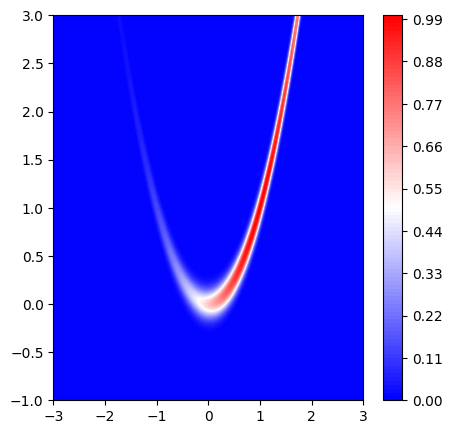

In [75]:
# create an isotropic Gaussian
dist = Banana2D(noise_std = 0.1)

xmin, xmax = -3, 3
ymin, ymax = -1, 3
N_discr = 300
X, Y = np.meshgrid(np.linspace(xmin, xmax, N_discr), np.linspace(ymin, ymax, N_discr), indexing='ij')
X_flat = X.ravel()
Y_flat = Y.ravel()
Z_flat = dist.batch(jnp.array([X_flat, Y_flat]).T)
Z = Z_flat.reshape(X.shape)

# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.colorbar()
plt.show()

In [76]:
# compute empirical mean and covariance
N_samples = 10_000_000
samples = dist.sample(key, N_samples)

mu_accurate = jnp.mean(samples, axis=0)
cov_accurate = jnp.cov(samples.T)

In [77]:
# create the GAIS samples
gais = GAIS(logtarget=dist)

n_samples = 50_000
n_iter = 20
dim = 2
mu_init = jnp.zeros(dim)
cov_init = jnp.eye(dim)


# run the GAIS with the Gaussian family
key, key_ = jr.split(key)
output_gauss = gais.run(key = key_,
                  n_samples=n_samples,
                  n_iter=n_iter,
                  mu_init=mu_init,
                  cov_init=cov_init)

# run the GAIS with the Student family
key, key_ = jr.split(key)
output_student = gais.run(key = key_,
                  n_samples=n_samples,
                  n_iter=n_iter,
                  mu_init=mu_init,
                  cov_init=cov_init,
                  family='student',
                  deg=3)

Text(0.5, 1.05, 'Generalized Adaptive Importance Sampling: Banana2D target')

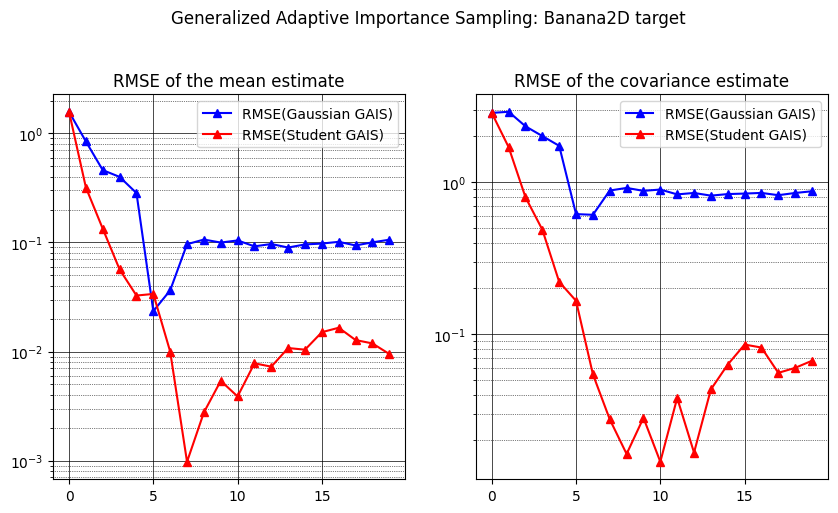

In [78]:
plt.figure(figsize=(10, 5))

# Mean estimate
plt.subplot(1, 2, 1)
mu_delta_gauss = np.array(output_gauss["mu_traj"]) - mu_accurate[None, :]
mu_RMSE_gauss = np.sqrt(np.mean(mu_delta_gauss**2, axis=1))

mu_delta_student = np.array(output_student["mu_traj"]) - mu_accurate[None, :]
mu_RMSE_student = np.sqrt(np.mean(mu_delta_student**2, axis=1))

plt.plot(mu_RMSE_gauss, "b-^", label="RMSE(Gaussian GAIS)")
plt.plot(mu_RMSE_student, "r-^", label="RMSE(Student GAIS)")
plt.yscale('log')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.legend()

plt.title("RMSE of the mean estimate")

# covariance estimate
plt.subplot(1, 2, 2)
cov_delta_gauss = np.array(output_gauss["cov_traj"]) - cov_accurate[None, :, :]
cov_RMSE_gauss = np.sqrt(np.mean(cov_delta_gauss**2, axis=(1, 2)))

cov_delta_student = np.array(output_student["cov_traj"]) - cov_accurate[None, :, :]
cov_RMSE_student = np.sqrt(np.mean(cov_delta_student**2, axis=(1, 2)))

plt.plot(cov_RMSE_gauss, "b-^", label="RMSE(Gaussian GAIS)")
plt.plot(cov_RMSE_student, "r-^", label="RMSE(Student GAIS)")
plt.yscale('log')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.legend()

plt.title("RMSE of the covariance estimate")

# add global title with a bit of space below the titles
plt.suptitle(r"Generalized Adaptive Importance Sampling: Banana2D target", y=1.05)


Text(0.5, 1.0, 'Effective Sample Size')

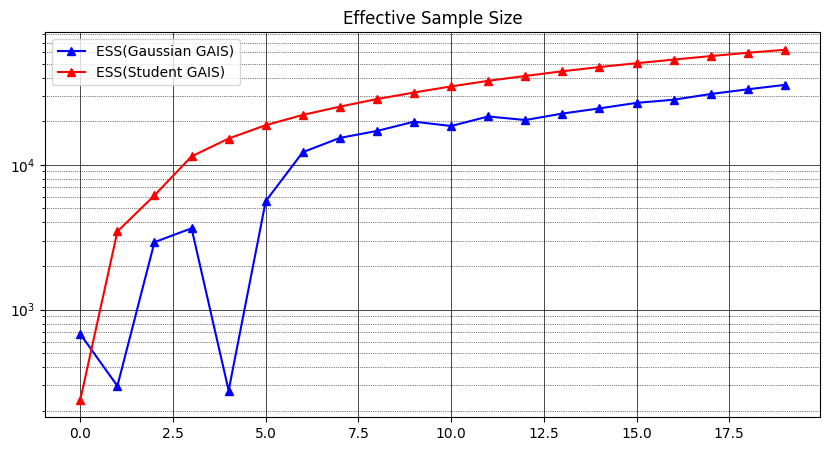

In [79]:
# plot the effective sample size
plt.figure(figsize=(10, 5))
plt.plot(output_gauss["ess"], "b-^", label="ESS(Gaussian GAIS)")
plt.plot(output_student["ess"], "r-^", label="ESS(Student GAIS)")
plt.yscale('log')

plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.legend()

plt.title("Effective Sample Size")